In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.float_format', '{:.3f}'.format)
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, basinhopping #최적화 패키지
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Callable, Tuple

from strategies import Strategies
from base_setting import *

from tool_kits import *
from performance import *
from visualize import *

def indexing(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(['Date'])
    return df


df_price = pd.read_csv('data/df_close.csv')
#df_price.rename(columns={'BF-B': 'BFB'}, inplace=True)
#df_price.drop(columns=['AMCR','CTAS'],inplace=True)
df_spy = pd.read_csv('data/df_spy.csv')
df_rf = pd.read_csv('data/df_rf.csv')
df_raw_div = pd.read_csv('data/raw_dividend.csv')
df_adj_div = pd.read_csv('data/dividend_adj.csv')
df_fund = pd.read_excel('data/fundamental.xlsx',sheet_name=None)
for i in df_fund:
    df_fund[i] = df_fund[i].set_index('Year').T.iloc[::-1]

dy = dict()
for i in df_fund.keys():
    dy[i] = df_fund[i]['Dividend Yield']

df_dy = pd.DataFrame(dy)

df_price = indexing(df_price)
df_spy = indexing(df_spy)
df_rf = indexing(df_rf)
df_raw_div = indexing(df_raw_div)
df_adj_div = indexing(df_adj_div)

df_price.drop(columns=['LIN'],inplace=True)
df_raw_div.drop(columns=['LIN'],inplace=True)
df_adj_div.drop(columns=['LIN'],inplace=True)

#  # Drop duplicate indices
# df_raw_div = df_raw_div[~df_raw_div.index.duplicated(keep='first')]


In [2]:
print(df_adj_div.shape,df_dy.shape,df_price.shape)

(1503, 63) (11, 63) (3367, 63)


In [3]:
df_fund['ABBV']['Dividend Yield']

2014        0.025
2015        0.034
2016        0.036
2017        0.026
2018        0.039
2019        0.048
2020        0.044
2021        0.038
2022        0.035
2023        0.038
Current    0.0364
Name: Dividend Yield, dtype: object

In [4]:
dy['ADM'] #.astype(float)

2014        0.018
2015        0.031
2016        0.026
2017        0.032
2018        0.033
2019         0.03
2020        0.029
2021        0.022
2022        0.017
2023        0.025
Current    0.0313
Name: Dividend Yield, dtype: object

In [5]:
diffs = {}
for i in df_adj_div.columns:
    diff = df_adj_div[df_adj_div[i].notnull()][i].diff().dropna()
    resample_diff = diff[diff != 0 ].resample('Y').mean()
    resample_diff.index = resample_diff.index.year
    resample_diffs = resample_diff.bfill()
    diffs[i] = resample_diffs
df_gap = pd.DataFrame(diffs)
df_gap.drop(index=[2013,2024],inplace=True)

df_gap['CHRW'].iloc[-1] = 0.06 #홀로 결측치 전년도 같다고 가정

df_gap

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014,0.020,0.080,0.050,0.068578,0.010,0.035,0.015,0.055504,0.020,0.053659,...,0.016666,0.06,0.02,0.02,0.01,0.09,0.06,0.003333,0.01,0.06
2015,0.045,0.020,0.040,0.040000,0.010,0.015,0.020,0.037003,0.030,0.058536,...,0.040000,0.03,0.03,0.03,0.01,0.04,0.08,0.003333,0.01,0.04
2016,0.060,0.020,0.020,0.040000,0.010,0.015,0.025,0.055347,0.030,0.068293,...,0.056667,0.08,0.03,0.03,0.01,0.04,0.02,0.003334,0.01,0.02
2017,0.070,0.005,0.020,0.060000,0.010,0.015,0.020,0.090000,0.035,0.019512,...,0.003333,0.03,0.05,0.05,0.02,0.02,0.03,0.003333,0.01,0.02
2018,0.160,0.015,0.015,0.080000,0.035,0.015,0.040,0.150000,0.040,0.019513,...,0.003334,0.07,0.09,0.03,0.03,0.02,0.13,0.003333,0.01,0.05
2019,0.110,0.040,0.015,0.120000,0.010,0.033,0.020,0.060000,0.050,0.019512,...,0.090000,0.03,0.07,0.03,0.03,0.02,0.06,0.003334,0.01,0.05
2020,0.110,0.040,0.010,0.020000,0.010,0.017,0.020,0.180000,0.050,0.039024,...,0.070000,0.02,0.10,0.01,0.06,0.02,0.14,0.003333,0.01,0.01
2021,0.120,0.090,0.010,0.110000,0.050,0.005,0.020,0.160000,0.055,0.039024,...,0.103333,0.09,0.10,0.09,0.02,0.22,0.18,0.003333,0.01,0.01
2022,0.110,0.020,0.030,0.210000,0.070,0.005,0.020,0.120000,0.060,0.030610,...,0.050000,0.03,0.08,0.01,0.02,0.18,0.12,0.003334,0.01,0.03


In [6]:
div_avg = df_raw_div.loc['2014':].resample('Y').mean()
sr = div_avg.isnull().sum()
sr[sr!=0]
div_avg[['EXPD',"MKC"]] #2024 div are empty

div_avg.drop(index=['2024-12-31'],inplace=True)
div_avg.index = div_avg.index.year
df_gi = df_gap / div_avg
df_gi

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014,0.048193,0.363636,0.208333,0.156369,0.053333,0.127273,0.200000,0.077922,0.053333,0.098435,...,0.090906,0.098361,0.066667,0.039216,0.034188,0.189474,0.136364,0.020831,0.097561,0.088889
2015,0.089109,0.083333,0.142857,0.080000,0.050633,0.051724,0.210526,0.049383,0.075472,0.097560,...,0.179105,0.045802,0.090909,0.056075,0.033333,0.074074,0.098039,0.020406,0.088889,0.055556
2016,0.105263,0.076923,0.066667,0.074074,0.048193,0.049180,0.208333,0.066862,0.070175,0.103322,...,0.202382,0.112676,0.083333,0.053097,0.032258,0.068966,0.037037,0.020004,0.081633,0.026846
2017,0.109375,0.018868,0.062500,0.102564,0.045977,0.046875,0.142857,0.094737,0.076294,0.027211,...,0.011764,0.039216,0.121951,0.082645,0.060606,0.032787,0.052632,0.019606,0.075472,0.026144
2018,0.178273,0.053571,0.044776,0.114286,0.134615,0.044776,0.210526,0.136364,0.080808,0.026491,...,0.011630,0.085890,0.180000,0.046512,0.083333,0.031746,0.185714,0.019229,0.070175,0.061920
2019,0.102804,0.125000,0.042857,0.146341,0.037037,0.089674,0.088889,0.051724,0.093023,0.025806,...,0.238938,0.034682,0.122807,0.044444,0.076923,0.030769,0.078947,0.018872,0.065574,0.058309
2020,0.093220,0.111111,0.027778,0.021858,0.035714,0.044156,0.081633,0.134328,0.085106,0.049999,...,0.156716,0.022472,0.149254,0.014388,0.133333,0.029851,0.155556,0.018517,0.061538,0.011494
2021,0.092308,0.200000,0.027027,0.114883,0.151515,0.012821,0.075472,0.106667,0.086106,0.047619,...,0.187878,0.095238,0.129870,0.120805,0.043478,0.278481,0.122951,0.018180,0.057971,0.011461
2022,0.078014,0.042553,0.075000,0.192220,0.175000,0.012658,0.070175,0.074074,0.086331,0.034995,...,0.083333,0.029851,0.096386,0.012579,0.041667,0.181818,0.100000,0.017861,0.054795,0.033803


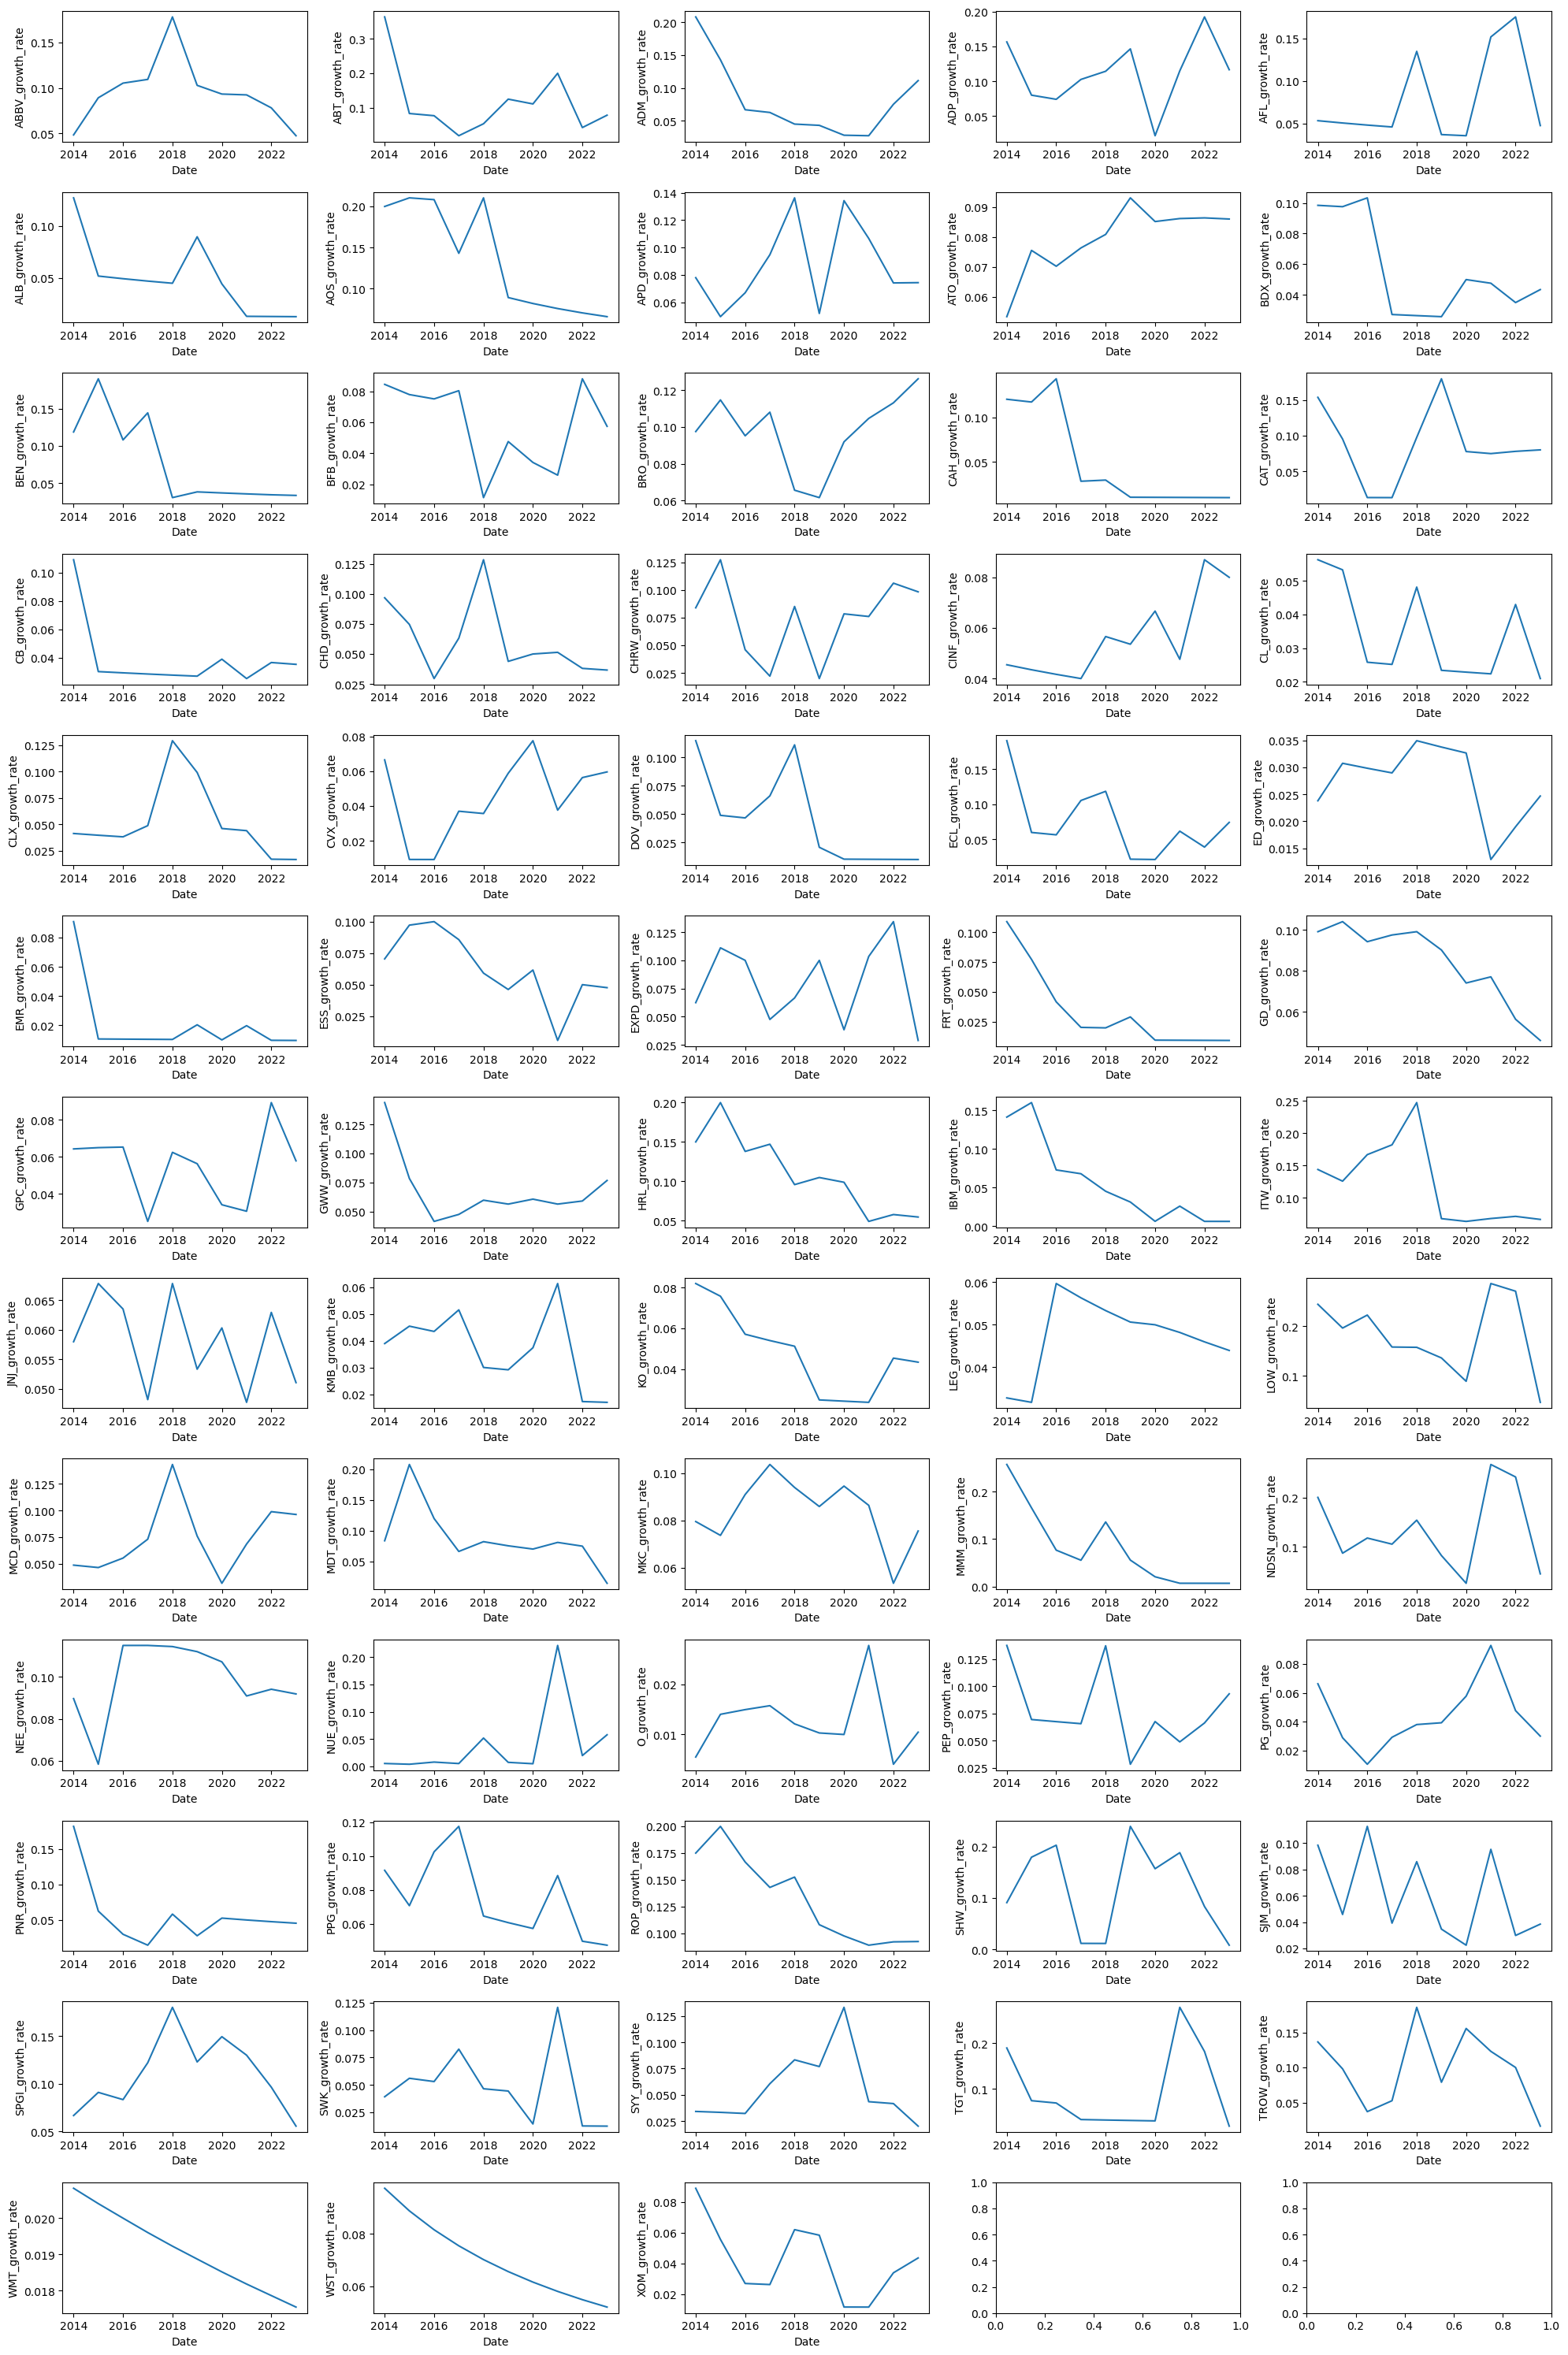

In [7]:
# 10x5 subplot 생성
# 극단값 확인
fig, axs = plt.subplots(13, 5, figsize=(20, 30))

# dividend 데이터의 열 인덱스에 따라 subplot에 그래프 그리기
for i,j in enumerate(df_gi):
    row = i // 5  # 행 인덱스 계산
    col = i % 5   # 열 인덱스 계산

    sample = df_gi[j].loc['2013':]
    axs[row, col].plot(sample)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel(f'{j}_growth_rate')

plt.tight_layout()
plt.show()

In [8]:
year_start_price = df_price.loc['2014':'2023'].resample('Y').first()
year_end_price = df_price.loc['2014':'2023'].resample('Y').last()
yearly_period_change = (year_end_price-year_start_price)/year_start_price
yearly_period_change.index = yearly_period_change.index.year
yearly_period_change

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014,0.258946,0.177609,0.209584,0.189061,-0.073833,-0.047672,0.057952,0.294239,0.247817,0.275060,...,0.442026,-0.010291,0.144437,0.198304,0.104955,0.201488,0.039971,0.088328,0.093673,-0.073183
2015,-0.100926,0.000223,-0.294887,0.017169,-0.019319,-0.071298,0.367792,-0.105343,0.127728,0.101745,...,-0.010822,0.227508,0.111888,0.111539,0.028858,-0.036108,-0.166395,-0.286380,0.154525,-0.160293
2016,0.086964,-0.105288,0.273717,0.252346,0.176073,0.549595,0.259643,0.203417,0.188873,0.118959,...,0.054917,0.046413,0.134388,0.093640,0.363457,-0.017947,0.072233,0.124634,0.472743,0.165247
2017,0.549591,0.461460,-0.132280,0.132271,0.258134,0.452470,0.290105,0.144212,0.152113,0.296155,...,0.493553,-0.036675,0.562875,0.466004,0.104182,-0.103093,0.383571,0.438246,0.173665,-0.079767
2018,-0.063205,0.230311,0.021951,0.130442,0.035808,-0.414050,-0.306030,-0.032989,0.090310,0.034337,...,-0.048924,-0.244342,0.010826,-0.289419,0.035702,-0.022771,-0.104385,-0.055178,-0.014774,-0.198048
2019,-0.007733,0.249784,0.131868,0.310128,0.162127,-0.064908,0.095928,0.472461,0.244964,0.235778,...,0.487750,0.109182,0.607595,0.372815,0.378566,0.929711,0.326655,0.273195,0.559278,0.001291
2020,0.196538,0.259229,0.093255,0.034523,-0.166448,1.031676,0.147582,0.182054,-0.135441,-0.081896,...,0.285145,0.131780,0.183163,0.062731,-0.122844,0.400254,0.209572,0.211956,0.867075,-0.418618
2021,0.284508,0.289891,0.355324,0.459399,0.351933,0.531612,0.592174,0.134452,0.114219,0.003111,...,0.460296,0.174609,0.416144,0.113788,0.086295,0.302933,0.331437,-0.012557,0.642364,0.474458
2022,0.193398,-0.210371,0.367654,-0.021106,0.234598,-0.083703,-0.315065,0.042088,0.067232,0.029412,...,-0.300159,0.158333,-0.273607,-0.595977,-0.031666,-0.357448,-0.439511,-0.019772,-0.472215,0.735914


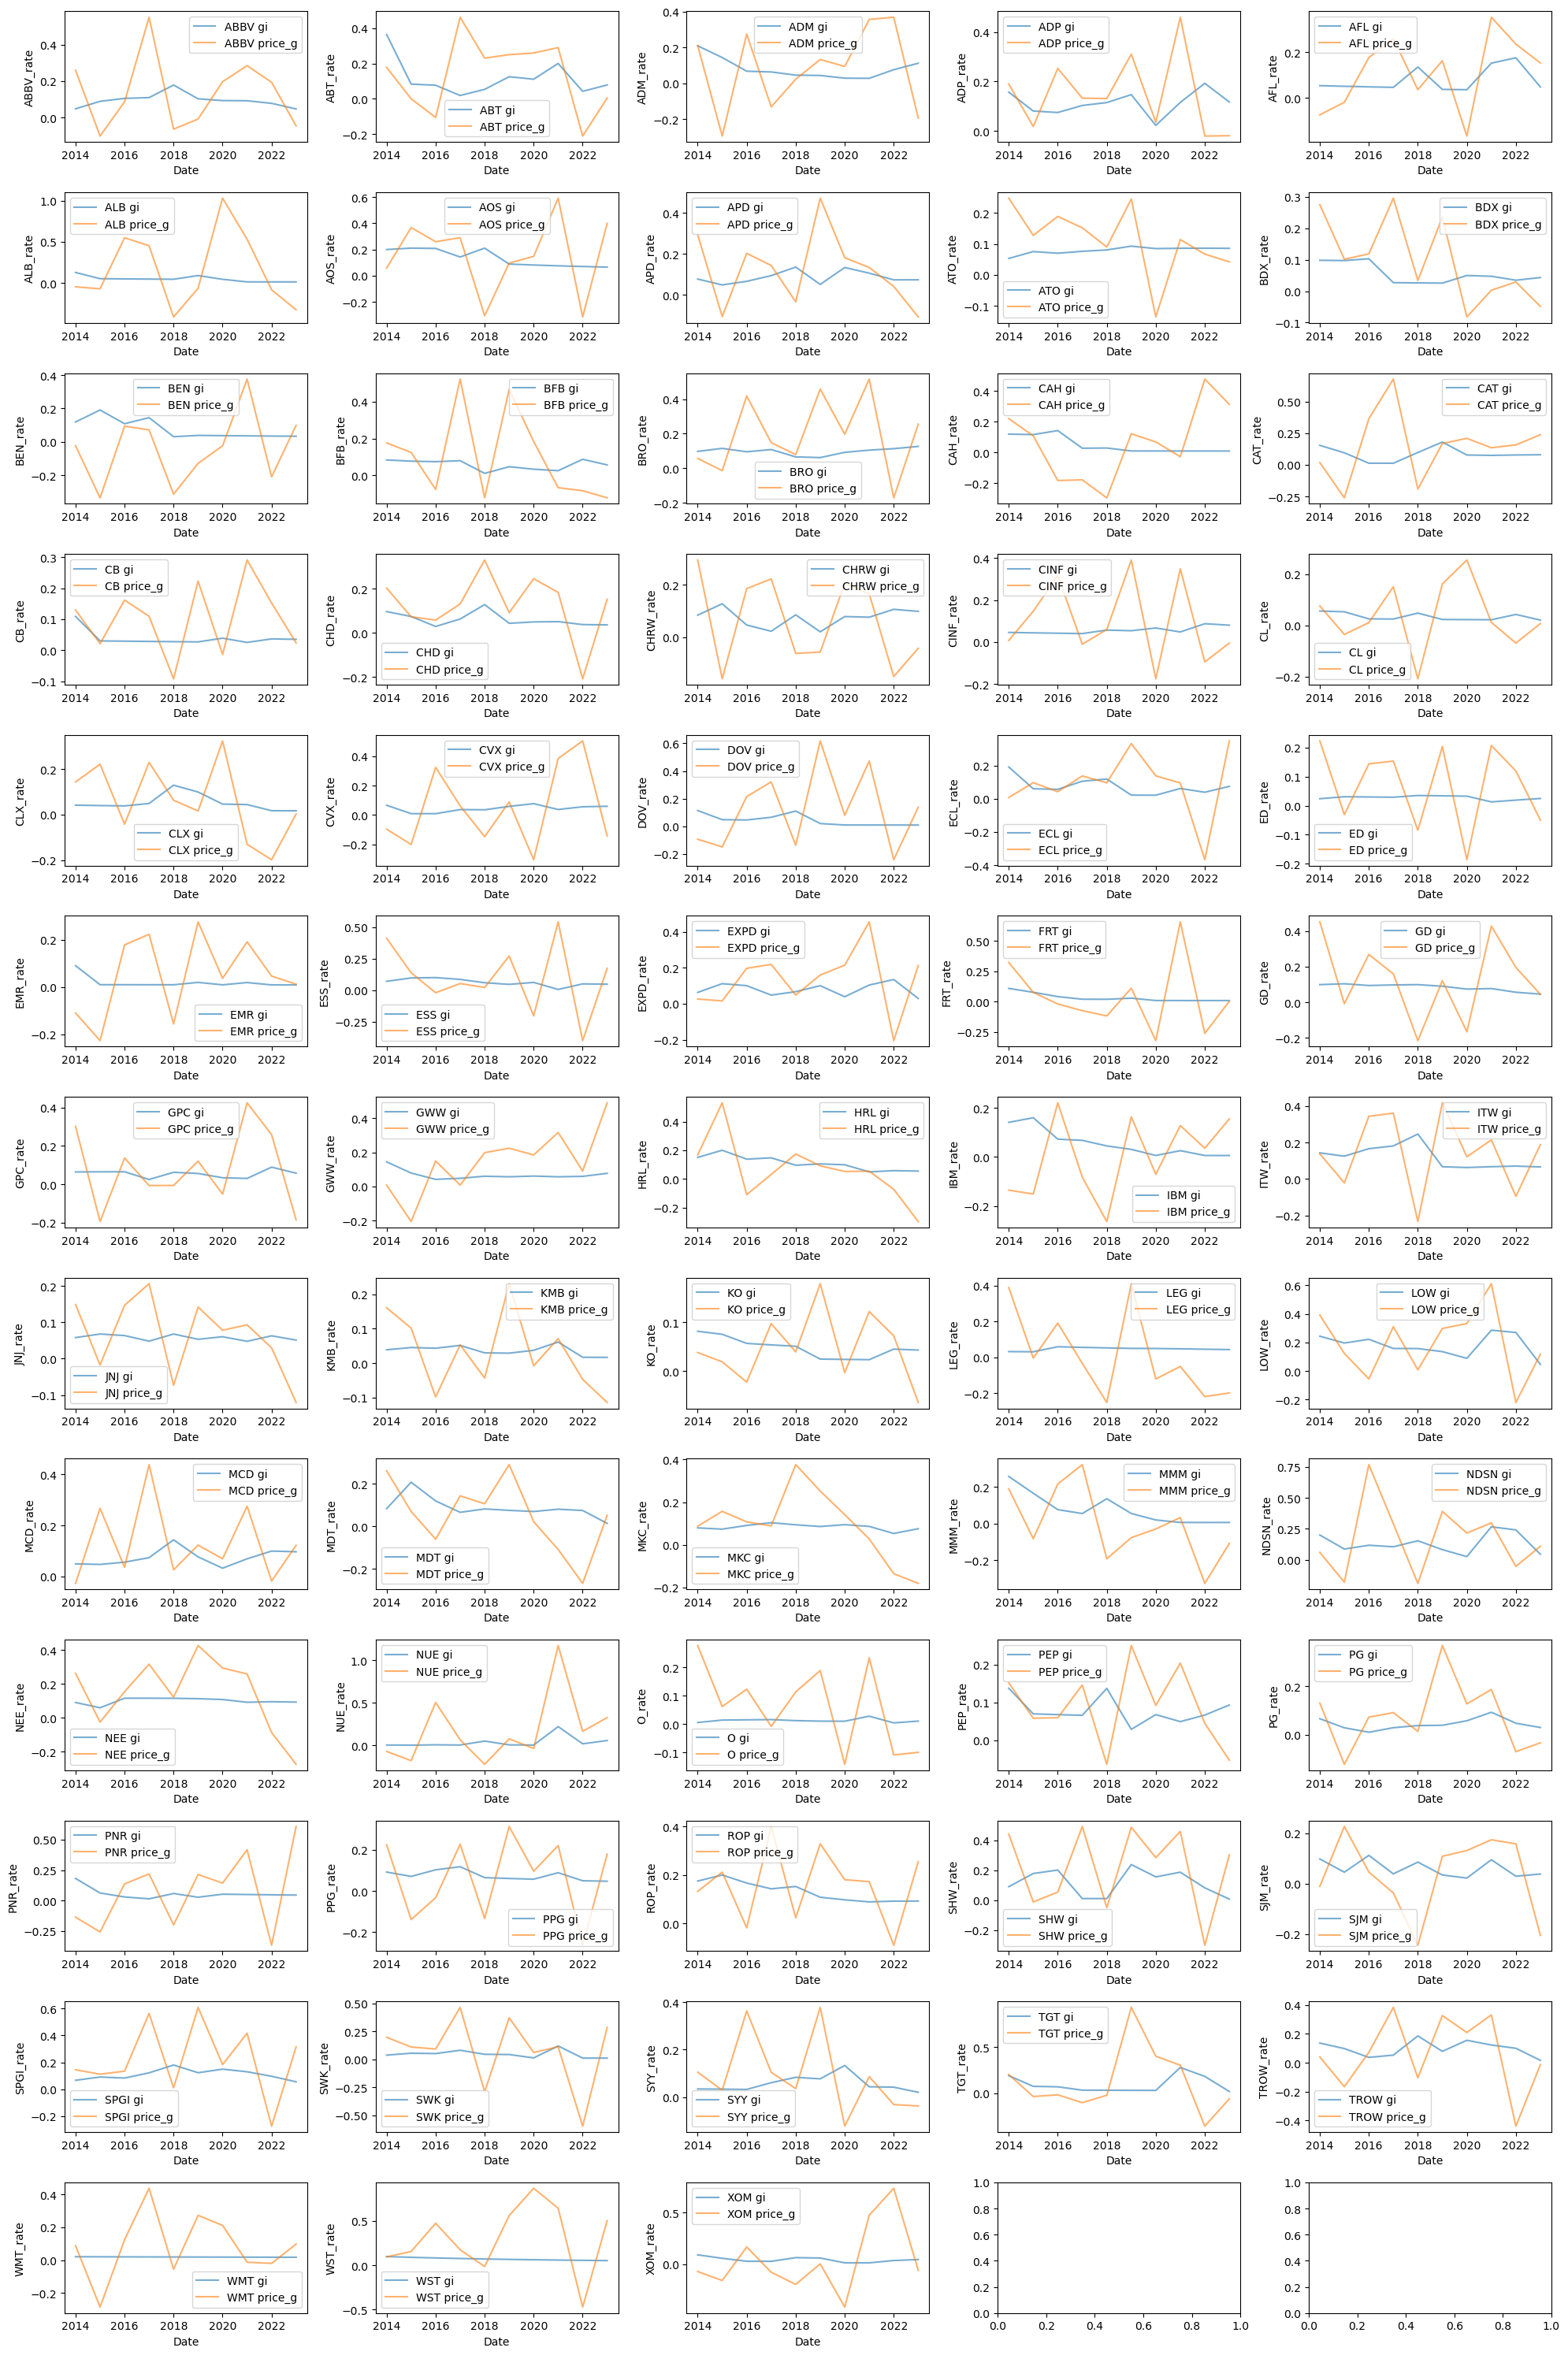

In [9]:
# 10x5 subplot 생성
# 극단값 확인
fig, axs = plt.subplots(13, 5, figsize=(20, 30))

# dividend 데이터의 열 인덱스에 따라 subplot에 그래프 그리기
for i,j in enumerate(df_gi.columns):
    row = i // 5  # 행 인덱스 계산
    col = i % 5   # 열 인덱스 계산

    gi = df_gi[j]
    price_g = yearly_period_change[j]
    axs[row, col].plot(gi.index, gi, label=f'{j} gi', alpha=0.6)
    axs[row, col].plot(price_g.index, price_g, label=f'{j} price_g', alpha=0.6)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel(f'{j}_rate')
    axs[row, col].legend()

plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import basinhopping

class Optimizing():
    """
    Base class for optimizing
    """

    def __init__(self,
                price: pd.DataFrame
                ,investment_period: list
                ,initial_investment: int
                ,rf: pd.DataFrame
                ,div: pd.DataFrame
                ,div_gi: pd.DataFrame
                ,div_di: pd.DataFrame
                ,fund: dict
                ):
        self.price = price
        self.investment_period = investment_period
        self.start_date = price.loc[investment_period[0]:].index[0]
        self.end_date = price.loc[:investment_period[1]].index[-1]
        self.initial_investment = initial_investment
        self.rf = rf
        self.div = div
        self.div_gi = div_gi
        self.div_di = div_di
        self.fundamental = fund

        self.ticker_lst = price.columns.to_list()

        #need to OOP
        self.current_price = price.loc[self.start_date]
        self.past_period_price = price.loc[:self.start_date]


    def sharpe_obj(self,x): #목적함수 구현

        x = np.array(x)

        seed = np.dot(x, self.current_price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액

        weights = (x*self.current_price)/ seed # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]

        er = (self.past_period_price.iloc[-252:,:].pct_change().dropna().mean()) * 252 # 252을 start-end 해서 실제 영업일 기준 투자 기간으로 바꿔도 좋을듯

        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]

        cov = self.past_period_price.iloc[-252:,:].pct_change().dropna().cov() # 공분산

        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)

        std = np.sqrt(variance) #시그마, 표준편차

        standard_ER = np.dot(weights,er)

        standard_sharpe = -(standard_ER-rf)/std

        return standard_sharpe

    def gorden_obj(self,x): #목적함수 구현

        x = np.array(x)

        seed = np.dot(x, self.current_price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액

        weights = (x*self.current_price)/ seed # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]

        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]

        cov = self.past_period_price.iloc[-252:,:].pct_change().dropna().cov() # 공분산

        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)

        std = np.sqrt(variance) #시그마, 표준편차

        growth_rate = self.loc[self.start_date -1]

        div_rate = self.df_dy.loc[self.start_date -1]

        ep = np.dot(weights,growth_rate) + np.dot(weights,div_rate*(1+growth_rate)) #기대 자본성장률 + 기대배당수익률

        custom_sharpe = -(ep-rf)/std

        return custom_sharpe

    def optimizing_weight(self):
        """
        Optimize given obj,params,cons to return weight
        """

        # self.period? (투자 기간이 필요할듯) # version 1에서는 과거1년으로 고정

        #예상 주당 배당금 ( 추후 Gi 곱을 통해 미래 추정값으로 바꿔야함)
        expect_div = self.div.loc[:str(self.start_date.year-1)]
        expect_growth = self.div_gi.loc[:str(self.start_date.year-1)]
        expect_div = expect_div*(1+expect_growth)

        min_month_div = self.initial_investment*(0.01)*(1/12)

        num_stocks = len(self.ticker_lst)

        #boundary
        bnds = ((0,None), ) * num_stocks # Long only port
        #initial decision variable
        x0 = np.array([100] * num_stocks)
        #setting constraints

        #제약식 제약식에 해당하는 등식, 수식을 list 형식으로 모아줌, list 안에는 또 dict 형식으로 넣음)
        #1: 주식분배금액 = 초기 투자금액
        cons = [{'type': 'eq', 'fun': lambda x: np.dot(x,self.current_price)-self.initial_investment}]  # {좌변 - 우변 = 0} 투자할돈 = 들고있는 돈

        #2: 예상 배당금을 매달 300 달러 이상!
        for i in range(0,12):
            cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, expect_div.iloc[i,:]) - min_month_div})

        #3: 개별 종목 비중이 20% 이상이지 못하게
        for i in range(num_stocks):
            cons.append({'type': 'ineq', 'fun': lambda x: 0.2 - (np.dot(x,self.current_price)/self.initial_investment)})


        # collect minimizer_kwargs
        minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}

        # 전역 최적화를 수행하는 알고리즘으로, 특히 최적화 문제가 복잡하고 지역 최소값(local min)에 갇힐 위험이 있는 경우에 유용합니다.
        # 이 메소드는 여러 시작점에서 로컬 최소화를 시도하여 전역 최소값(global minimum)을 찾는 방식으로 작동합니다.
        res = basinhopping(self.obj, x0, minimizer_kwargs=minimizer_kwargs, niter=10)

        weight = (res.x * self.current_price) / np.dot(res.x, self.current_price)  # 최적의 투자 비중

        return weight

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import basinhopping

class Optimizing:
    """
    Base class for optimizing
    """

    def __init__(self,
                 price: pd.DataFrame,
                 investment_period: list,
                 initial_investment: int,
                 rf: pd.DataFrame,
                 div: pd.DataFrame,
                 div_gi: pd.DataFrame,
                 div_di: pd.DataFrame,
                 fund: dict):
        self.price = price
        self.investment_period = investment_period
        self.start_date = price.loc[investment_period[0]:].index[0]
        self.end_date = price.loc[:investment_period[1]].index[-1]
        self.initial_investment = initial_investment
        self.rf = rf
        self.div = div
        self.div_gi = div_gi
        self.div_di = div_di
        self.fundamental = fund

        self.ticker_lst = price.columns.to_list()
        self.current_price = price.loc[self.start_date]
        self.past_period_price = price.loc[:self.start_date]

    def sharpe_obj(self, x):
        x = np.array(x)
        seed = np.dot(x, self.current_price)
        weights = (x * self.current_price) / seed

        er = (self.past_period_price.iloc[-252:, :].pct_change().dropna().mean()) * 252
        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]
        cov = self.past_period_price.iloc[-252:, :].pct_change().dropna().cov()
        variance = np.dot(weights.T, np.dot(cov, weights))
        std = np.sqrt(variance)
        standard_ER = np.dot(weights, er)
        standard_sharpe = -(standard_ER - rf) / std

        return standard_sharpe

    def gorden_obj(self, x):
        x = np.array(x)
        seed = np.dot(x, self.current_price)
        weights = (x * self.current_price) / seed

        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]
        cov = self.past_period_price.iloc[-252:, :].pct_change().dropna().cov()
        variance = np.dot(weights.T, np.dot(cov, weights))
        std = np.sqrt(variance)

        growth_rate = self.div_gi.loc[self.start_date.year - 1]
        div_rate = self.div_di.loc[self.start_date.year - 1]
        ep = np.dot(weights, growth_rate) + np.dot(weights, div_rate * (1 + growth_rate))
        custom_sharpe = -(ep - rf) / std

        return custom_sharpe

    def optimizing_weight(self, obj_function='sharpe_obj'):
        one_year_ago = self.start_date - pd.DateOffset(years=1)
        expect_div = self.div.loc[one_year_ago:self.start_date]
        expect_growth = self.div_gi.loc[self.start_date.year - 1]
        expect_div = expect_div * (1 + expect_growth)
        min_month_div = self.initial_investment * (0.01) * (1 / 12)
        num_stocks = len(self.ticker_lst)

        bnds = ((0, None),) * num_stocks
        x0 = np.array([100] * num_stocks)

        cons = [{'type': 'eq', 'fun': lambda x: np.dot(x, self.current_price) - self.initial_investment}]
        for i in range(12):
            cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, expect_div.resample('M').sum().iloc[i, :]) - min_month_div})
        for i in range(num_stocks):
            cons.append({'type': 'ineq', 'fun': lambda x: 0.2 - (np.dot(x, self.current_price) / self.initial_investment)})

        minimizer_kwargs = {"method": "SLSQP", "constraints": cons, "bounds": bnds}
        obj_func = getattr(self, obj_function)
        res = basinhopping(obj_func, x0, minimizer_kwargs=minimizer_kwargs, niter=10)

        weight = (res.x * self.current_price) / np.dot(res.x, self.current_price)

        return weight


In [12]:
tot = df_adj_div.loc['2014-01-01':'2014-12-31']*df_gi.loc[2014]
tot.resample('M').sum()

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.019277,0.08,0.00,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.009756,0.000000
2014-02-28,0.000000,0.00,0.05,0.000000,0.009867,0.000,0.015,0.000000,0.019733,0.000000,...,0.016666,0.057049,0.02,0.000000,0.000000,0.081474,0.00,0.000000,0.000000,0.056000
2014-03-31,0.000000,0.00,0.00,0.065897,0.000000,0.035,0.000,0.055504,0.000000,0.052339,...,0.000000,0.000000,0.00,0.019608,0.000000,0.000000,0.06,0.003333,0.000000,0.000000
2014-04-30,0.020241,0.08,0.00,0.000000,0.000000,0.000,0.015,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.009915,0.000000,0.00,0.000000,0.009756,0.000000
2014-05-31,0.000000,0.00,0.05,0.000000,0.009867,0.000,0.000,0.000000,0.019733,0.000000,...,0.016666,0.057049,0.02,0.000000,0.000000,0.081474,0.00,0.003333,0.000000,0.061333
2014-06-30,0.000000,0.00,0.00,0.065897,0.000000,0.035,0.000,0.055504,0.000000,0.052339,...,0.000000,0.000000,0.00,0.019608,0.000000,0.000000,0.06,0.000000,0.000000,0.000000
2014-07-31,0.020241,0.08,0.00,0.000000,0.000000,0.000,0.015,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.009915,0.000000,0.00,0.000000,0.009756,0.000000
2014-08-31,0.000000,0.00,0.05,0.000000,0.009867,0.000,0.000,0.000000,0.019733,0.000000,...,0.016666,0.062951,0.02,0.000000,0.000000,0.098526,0.00,0.003333,0.000000,0.061333
2014-09-30,0.000000,0.00,0.00,0.065897,0.000000,0.035,0.000,0.055504,0.000000,0.052339,...,0.000000,0.000000,0.00,0.020392,0.000000,0.000000,0.06,0.000000,0.000000,0.000000


In [13]:
# 투자 유니버스 가격 데이터
# price = df_price.copy()

# investment_period = i_p :백테스팅할 투자 기간
i_p = ['2016-01-01','2017-01-01']

# initial_investment = 초기 투자 금액
inv = 100000  # 1.3억

# 객체 할당
basic_set = Base_setting(df_price,i_p,inv,df_rf)

simple_sharpe = Optimizing(price=df_price
                           ,investment_period=i_p
                           ,initial_investment=inv
                           ,rf=df_rf
                           ,div=df_adj_div
                           ,div_gi=df_gi
                           ,div_di=df_dy
                           ,fund=df_fund)


In [14]:
simple_sharpe = Optimizing(price=df_price
                           ,investment_period=i_p
                           ,initial_investment=inv
                           ,rf=df_rf
                           ,div=df_adj_div
                           ,div_gi=df_gi
                           ,div_di=df_dy
                           ,fund=df_fund)

#sharpe_weight = simple_sharpe.optimizing_weight(obj_function='gorden_obj')

In [15]:
#sharpe_weight

In [16]:
# import pickle

# # 예시 데이터 (계산된 비중 데이터)
# weight = sharpe_weight.to_dict()

# # 객체를 pickle 파일로 저장
# with open('weights.pkl', 'wb') as f:
#     pickle.dump(weight, f)


In [17]:
import pickle

# pickle 파일에서 객체 불러오기
with open('weights.pkl', 'rb') as f:
    sharpe_weight = pickle.load(f)

sharpe_weight


FileNotFoundError: [Errno 2] No such file or directory: 'weights.pkl'

In [ ]:
# invest = sharpe_weight*10000
# numb_of_stock = invest / simple_sharpe.current_price
# # i 종목 갯수 * 주당 배당금 =i 종목으로 번 배당금
# div_table = df_raw_div.loc[simple_sharpe.start_date:simple_sharpe.end_date] * numb_of_stock
# div_table.resample('M').sum().sum(axis=1).plot()

TypeError: unsupported operand type(s) for *: 'dict' and 'int'

In [ ]:
simple_sharpe.current_price

ABBV    57.610001
ABT     42.930000
ADM     35.840000
ADP     82.070000
AFL     29.590000
          ...    
TGT     73.550003
TROW    70.190002
WMT     20.486668
WST     57.599998
XOM     77.459999
Name: 2016-01-04 00:00:00, Length: 63, dtype: float64

In [ ]:
tot = 0
for key in sharpe_weight:
    tot += key

tot

1.0000000000000002

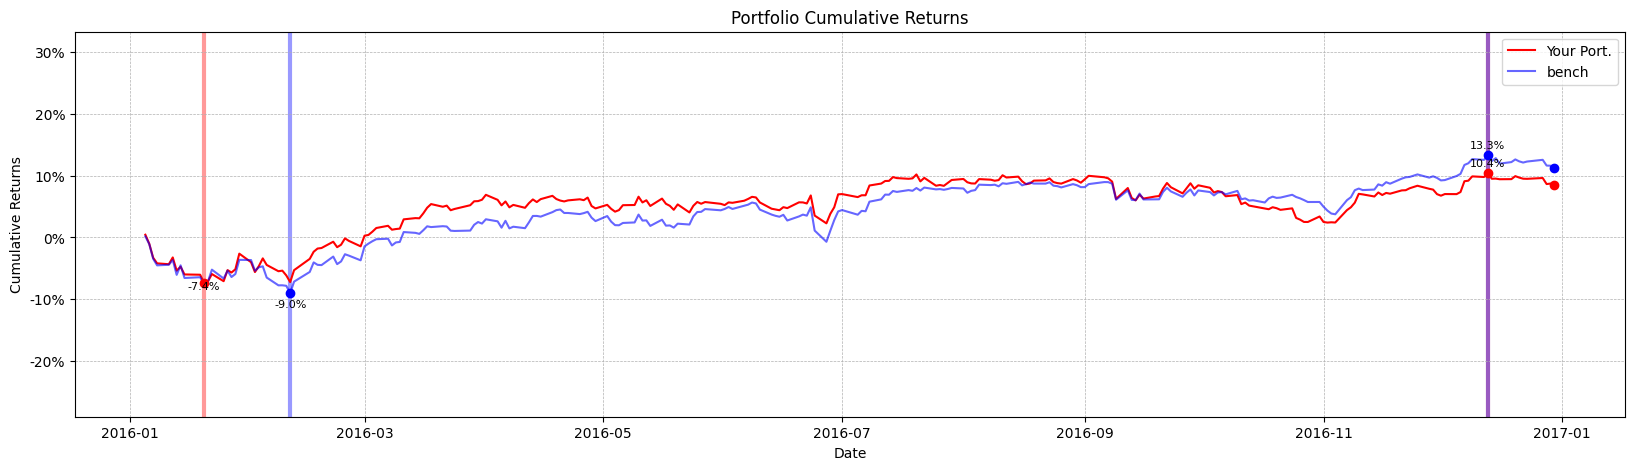

In [ ]:
# 투자 기간 동안 buy_and_hold 실시한 결과
buy_and_hold_port_return = basic_set.run_all(sharpe_weight)

#비교할 벤치마크 수익률 계산
bench_return = basic_set.benchmark_return(df_spy)

# 비교해서 퍼포먼스를 나타내는 시각화 파일
visualize(buy_and_hold_port_return,bench_return)

In [ ]:
sharpe_weight

{'ABBV': 0.003746776596272405,
 'ABT': 0.0002920082008283074,
 'ADM': 0.010309764230582384,
 'ADP': 0.00014510832341067882,
 'AFL': 0.0006963205703459431,
 'ALB': 0.00024545689006346,
 'AOS': 0.019383771443692428,
 'APD': 1.5180207129008628e-08,
 'ATO': 0.011477519344842837,
 'BDX': 0.0003032848881922932,
 'BEN': 0.012420063307382339,
 'BFB': 0.0019983588512358383,
 'BRO': 0.005428567074177052,
 'CAH': 0.006688707145958833,
 'CAT': 0.012165965192531419,
 'CB': 1.8477685684511056e-12,
 'CHD': 0.009350613810234939,
 'CHRW': 0.016397721484019925,
 'CINF': 5.188030207610855e-09,
 'CL': 9.471038085783411e-06,
 'CLX': 0.00015522736670716748,
 'CVX': 1.1690481568167169e-14,
 'DOV': 6.66161498261332e-05,
 'ECL': 6.960911759136033e-05,
 'ED': 0.009703637076865794,
 'EMR': 6.680552359161535e-10,
 'ESS': 0.030645848617616062,
 'EXPD': 0.012744821640489594,
 'FRT': 8.498405116438885e-05,
 'GD': 0.005345300814006163,
 'GPC': 5.3463257438095363e-05,
 'GWW': 0.00016432890347946097,
 'HRL': 0.03025077

In [ ]:
df_num =basic_set.weight_to_num(sharpe_weight)
df_num = pd.DataFrame(df_num)
df_num = df_num.T
df_num

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
0,6.503691,0.680196,28.766083,0.17681,2.353229,0.441867,51.566298,0.000013,18.402308,0.210116,...,69.049552,0.000396,0.007813,8.977251e-07,20.2904,28.290858,40.192394,8.506323,0.117734,0.000001


In [ ]:
sr_num = basic_set.weight_to_num(sharpe_weight)

In [ ]:
basic_set.start_date

Timestamp('2016-01-04 00:00:00')

In [ ]:
def get_monthly_dividened():
  df_num =basic_set.weight_to_num(sharpe_weight)
  df_raw_div.loc[basic_set.start_date:basic_set.end_date]
  df_result = df_raw_div.loc[basic_set.start_date:basic_set.end_date].multiply(sr_num, axis=1)
  df_result.resample('M').sum().sum(axis=1)

Date
2016-01-31     98.160839
2016-02-29    329.493330
2016-03-31    137.474387
2016-04-30     98.336241
2016-05-31    346.242887
2016-06-30    102.562436
2016-07-31    143.548940
2016-08-31    353.348875
2016-09-30    120.218646
2016-10-31    112.759223
2016-11-30    362.609101
2016-12-31    122.257221
Freq: M, dtype: float64

In [ ]:
basic_set.calculate_port_value()

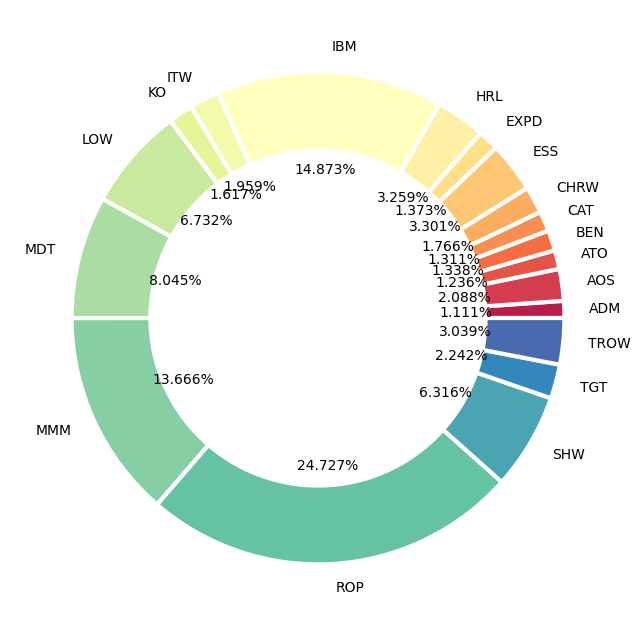

In [ ]:
import seaborn as sns

w_lst = []
t_lst = []
for i in range(len(sharpe_weight)):
    if sharpe_weight.iloc[i] > (0.01):
        w_lst.append(sharpe_weight.iloc[i])
        t_lst.append(sharpe_weight.index[i])

pal = sns.color_palette('Spectral', len(w_lst))

plt.figure(figsize=(8, 8))
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
plt.pie(w_lst, labels=t_lst, autopct='%.3f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [ ]:
std = simple_sharpe.start_date
std

Timestamp('2016-01-04 00:00:00')

In [ ]:
import numpy as np
a= np.array([1.2,1.4,3.3,0.6,0.999])
x1= np.array([10/35,10/35,5/35,20/15,100/35])

In [ ]:
np.dot(a,x1)

4.868571428571428

In [ ]:
class Optimizing():
    """
    Base class for optimizing
    """

    def __init__(self,
                data: pd.DataFrame
                ,investment_period: list
                ,initial_investment: int
                ,rf: pd.DataFrame
                ,div: pd.DataFrame
                ):
        self.data = data
        self.investment_period = investment_period
        self.start_date = data.loc[investment_period[0]:].index[0]
        self.end_date = data.loc[:investment_period[1]].index[-1]
        self.initial_investment = initial_investment
        self.rf = rf
        self.div = div
        self.ticker_lst = data.columns.to_list()

        #need to OOP
        self.current_price = data.loc[self.start_date]
        self.past_period_price = data.loc[:self.start_date]


    def sharpe_obj(self,x): #목적함수 구현

        x = np.array(x)

        seed = np.dot(x, self.current_price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액

        weights = (x*self.current_price)/ seed # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]

        er = (self.past_period_price.iloc[-252:,:].pct_change().dropna().mean()) * 252 # 252을 start-end 해서 실제 영업일 기준 투자 기간으로 바꿔도 좋을듯

        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]

        cov = self.past_period_price.iloc[-252:,:].pct_change().dropna().cov() # 공분산

        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)

        std = np.sqrt(variance) #시그마, 표준편차

        standard_ER = np.dot(weights,er)

        # Ep = np.dot(weights,growth_rate) + np.dot(weights,div_rate*(1+growth_rate)) #기대 자본성장률 + 기대배당수익률

        standard_sharpe = -(standard_ER-rf)/std

        #custom_sharpe = -(Ep-Rf)/std

        return standard_sharpe

    def gorden_obj(self,x): #목적함수 구현

        x = np.array(x)

        seed = np.dot(x, self.current_price) # 전체 투자 금액, 내적 개념, 종목수*종목가격 = 투자금액

        weights = (x*self.current_price)/ seed # 투자 비중 / 총투자비용 : [1번종목에 총투자비용대비 얼만큼투자함, ~~~~]

        rf = self.rf.resample('M').mean().loc[:self.start_date].iloc[-1][0]

        cov = self.past_period_price.iloc[-252:,:].pct_change().dropna().cov() # 공분산

        variance = np.dot(weights.T, np.dot(cov,weights)) # variance = sigma(wiwjcovij)

        std = np.sqrt(variance) #시그마, 표준편차

        Ep = np.dot(weights,growth_rate) + np.dot(weights,div_rate*(1+growth_rate)) #기대 자본성장률 + 기대배당수익률

        standard_sharpe = -(standard_ER-rf)/std

        #custom_sharpe = -(Ep-Rf)/std

        return standard_sharpe

    def optimizing_weight(self):
        """
        Optimize given obj,params,cons to return weight
        """

        # self.period? (투자 기간이 필요할듯) # version 1에서는 과거1년으로 고정

        #예상 주당 배당금 ( 추후 Gi 곱을 통해 미래 추정값으로 바꿔야함)
        expect_div = self.div.loc[:str(self.start_date.year-1)]

        min_month_div = self.initial_investment*(0.01)*(1/12)

        num_stocks = len(self.ticker_lst)

        #boundary
        bnds = ((0,None), ) * num_stocks # Long only port
        #initial decision variable
        x0 = np.array([100] * num_stocks)
        #setting constraints

        #제약식 제약식에 해당하는 등식, 수식을 list 형식으로 모아줌, list 안에는 또 dict 형식으로 넣음)
        #1: 주식분배금액 = 초기 투자금액
        cons = [{'type': 'eq', 'fun': lambda x: np.dot(x,self.current_price)-self.initial_investment}]  # {좌변 - 우변 = 0} 투자할돈 = 들고있는 돈

        #2: 예상 배당금을 매달 300 달러 이상!
        for i in range(0,12):
            cons.append({'type': 'ineq', 'fun': lambda x, i=i: np.dot(x, expect_div.iloc[i,:]) - min_month_div})

        #3: 개별 종목 비중이 20% 이상이지 못하게
        for i in range(num_stocks):
            cons.append({'type': 'ineq', 'fun': lambda x: 0.2 - (np.dot(x,self.current_price)/self.initial_investment)})


        # collect minimizer_kwargs
        minimizer_kwargs = {"method":"SLSQP", "constraints":cons, "bounds":bnds}

        # 전역 최적화를 수행하는 알고리즘으로, 특히 최적화 문제가 복잡하고 지역 최소값(local min)에 갇힐 위험이 있는 경우에 유용합니다.
        # 이 메소드는 여러 시작점에서 로컬 최소화를 시도하여 전역 최소값(global minimum)을 찾는 방식으로 작동합니다.
        res = basinhopping(self.obj, x0, minimizer_kwargs=minimizer_kwargs, niter=10)

        weight = (res.x * self.current_price) / np.dot(res.x, self.current_price)  # 최적의 투자 비중

        return weight

In [ ]:
df_div

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.075,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.00,0.0,0.63
2014-03-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.16,0.0,0.00
2014-04-01,0.42,0.22,0.00,0.000000,0.000,0.000,0.075,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.1,0.00
2014-05-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.000,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.16,0.0,0.69
2014-06-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,1.48,0.51,0.00,0.000000,0.000,0.000,0.320,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.0,0.00
2023-11-01,0.00,0.00,0.45,0.000000,0.420,0.000,0.000,0.000000,0.805,0.000000,...,0.605000,1.06,0.90,0.81,0.00,1.10,0.00,0.00,0.2,0.95
2023-12-01,0.00,0.00,0.00,1.400000,0.000,0.400,0.000,1.750000,0.000,0.950000,...,0.000000,0.00,0.00,0.00,0.00,0.00,1.22,0.19,0.0,0.00


In [ ]:
past_div = simple_sharpe.div.loc[:simple_sharpe.start_date]
Gi = []
for i in simple_sharpe.ticker_lst:
    Gi.append(np.exp(np.log(past_div[i][past_div[i] != 0].resample('Y').mean().pct_change().bfill()).mean()))

df_Gi = pd.DataFrame(columns=simple_sharpe.ticker_lst,data=np.array(Gi).reshape(1,len(Gi)))

In [ ]:
df_Gi

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
0,0.174042,0.08831,0.166667,0.140078,0.053333,0.054545,0.266667,0.051948,0.06,0.100672,...,0.218182,0.07377,0.1,0.04902,0.027984,0.136842,0.181818,0.020831,0.080652,0.066667


In [ ]:
df_div

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.075,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.00,0.0,0.63
2014-03-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.16,0.0,0.00
2014-04-01,0.42,0.22,0.00,0.000000,0.000,0.000,0.075,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.29,0.00,0.00,0.00,0.1,0.00
2014-05-01,0.00,0.00,0.24,0.000000,0.185,0.000,0.000,0.000000,0.370,0.000000,...,0.183333,0.58,0.30,0.00,0.00,0.43,0.00,0.16,0.0,0.69
2014-06-01,0.00,0.00,0.00,0.421422,0.000,0.275,0.000,0.712303,0.000,0.531707,...,0.000000,0.00,0.00,0.50,0.00,0.00,0.44,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,1.48,0.51,0.00,0.000000,0.000,0.000,0.320,0.000000,0.000,0.000000,...,0.000000,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.0,0.00
2023-11-01,0.00,0.00,0.45,0.000000,0.420,0.000,0.000,0.000000,0.805,0.000000,...,0.605000,1.06,0.90,0.81,0.00,1.10,0.00,0.00,0.2,0.95
2023-12-01,0.00,0.00,0.00,1.400000,0.000,0.400,0.000,1.750000,0.000,0.950000,...,0.000000,0.00,0.00,0.00,0.00,0.00,1.22,0.19,0.0,0.00


In [ ]:
df_Di = df_div.values / df_price.resample('M').mean().values
df_Di = pd.DataFrame(index=df_div.index,columns=df_div.columns,data=df_Di)
df_Di

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,0.000000,0.000000,0.007916,0.000000,0.007557,0.000000,0.003669,0.000000,0.010346,0.000000,...,0.003213,0.007998,0.004202,0.000000,0.000000,0.010047,0.000000,0.000000,0.000000,0.010455
2014-03-01,0.000000,0.000000,0.000000,0.007715,0.000000,0.004867,0.000000,0.008164,0.000000,0.005472,...,0.000000,0.000000,0.000000,0.007768,0.000000,0.000000,0.007599,0.007872,0.000000,0.000000
2014-04-01,0.012734,0.006981,0.000000,0.000000,0.000000,0.000000,0.003799,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010468,0.000000,0.000000,0.000000,0.002408,0.000000
2014-05-01,0.000000,0.000000,0.007156,0.000000,0.007554,0.000000,0.000000,0.000000,0.009360,0.000000,...,0.003014,0.007682,0.004259,0.000000,0.000000,0.009806,0.000000,0.007614,0.000000,0.010405
2014-06-01,0.000000,0.000000,0.000000,0.007533,0.000000,0.004433,0.000000,0.007819,0.000000,0.005297,...,0.000000,0.000000,0.000000,0.007093,0.000000,0.000000,0.007445,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.010330,0.005461,0.000000,0.000000,0.000000,0.000000,0.004749,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-01,0.000000,0.000000,0.006222,0.000000,0.005194,0.000000,0.000000,0.000000,0.007280,0.000000,...,0.002307,0.009667,0.002266,0.009315,0.000000,0.009199,0.000000,0.000000,0.000584,0.009218
2023-12-01,0.000000,0.000000,0.000000,0.006053,0.000000,0.002925,0.000000,0.006582,0.000000,0.004001,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011870,0.003706,0.000000,0.000000


In [ ]:
df_Di.resample('Y').sum()

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,0.035157,0.019607,0.027505,0.029417,0.031117,0.019535,0.014680,0.030036,0.038342,0.021167,...,0.011588,0.031954,0.016271,0.028594,0.040115,0.041369,0.029970,0.030154,0.007471,0.042409
2015-12-31,0.047566,0.024835,0.031280,0.028899,0.031069,0.025229,0.013121,0.028507,0.034887,0.019351,...,0.010513,0.029181,0.014369,0.025501,0.029499,0.035836,0.036889,0.032791,0.008399,0.051105
2016-12-31,0.053362,0.028879,0.037443,0.028022,0.029669,0.017686,0.013377,0.029526,0.028275,0.018317,...,0.013165,0.026621,0.014521,0.024333,0.033398,0.039435,0.038857,0.033291,0.007352,0.049807
2017-12-31,0.049003,0.025756,0.036784,0.025046,0.026489,0.011929,0.011789,0.029974,0.025857,0.016307,...,0.010642,0.030684,0.012215,0.020034,0.029684,0.049809,0.035446,0.028759,0.006132,0.052085
2018-12-31,0.049949,0.019777,0.034403,0.023755,0.026576,0.015405,0.014724,0.031037,0.025583,0.013940,...,0.008868,0.034341,0.011054,0.021015,0.025438,0.037733,0.031818,0.025681,0.005780,0.054146
2019-12-31,0.069049,0.017788,0.038770,0.022253,0.023729,0.021657,0.020386,0.024401,0.023252,0.013104,...,0.009753,0.035957,0.010386,0.021609,0.025393,0.033775,0.032912,0.021417,0.005148,0.059968
2020-12-31,0.064083,0.016262,0.037052,0.026670,0.030598,0.018117,0.022380,0.023663,0.025094,0.014342,...,0.008915,0.035169,0.008612,0.021916,0.033217,0.022079,0.033447,0.017834,0.003246,0.093718
2021-12-31,0.052889,0.016026,0.025666,0.019875,0.026352,0.008418,0.017343,0.022828,0.028728,0.014127,...,0.007986,0.032506,0.007969,0.016917,0.025882,0.014759,0.025153,0.016366,0.002002,0.067797
2022-12-31,0.041355,0.017218,0.019428,0.019870,0.026616,0.006866,0.019290,0.026526,0.025988,0.014315,...,0.009612,0.030441,0.009346,0.034130,0.025320,0.023150,0.042599,0.016437,0.002357,0.040727


In [ ]:
ABBV = pd.read_excel('/Users/yun/Downloads/portfolio_optimizing/data/fundamental.xlsx',sheet_name='ABBV')
ABBV.T[24]

Year       Dividend Yield
Current            0.0364
2023                0.038
2022                0.035
2021                0.038
2020                0.044
2019                0.048
2018                0.039
2017                0.026
2016                0.036
2015                0.034
2014                0.025
Name: 24, dtype: object

In [ ]:
df_Di.resample('Y').sum()['ABBV']

Date
2014-12-31    0.035157
2015-12-31    0.047566
2016-12-31    0.053362
2017-12-31    0.049003
2018-12-31    0.049949
2019-12-31    0.069049
2020-12-31    0.064083
2021-12-31    0.052889
2022-12-31    0.041355
2023-12-31    0.041071
2024-12-31    0.009612
Freq: A-DEC, Name: ABBV, dtype: float64

In [ ]:
(df_div.resample('Y').sum() / df_price.resample('Y').first())*100

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,4.052323,2.242234,3.262424,3.378510,3.165153,2.042625,1.545277,3.798347,4.141324,2.467648,...,1.372341,3.442620,1.799747,3.395336,4.443592,4.590455,3.299212,3.280493,0.703745,4.652672
2015-12-31,4.558335,2.561268,2.788478,2.937128,3.233264,2.185258,1.573216,2.784443,3.558446,2.009755,...,1.115018,3.372421,1.636990,2.742030,2.870008,3.719269,3.367638,2.763444,0.900635,4.681486
2016-12-31,5.697376,2.841753,4.230794,3.142517,3.419408,2.438490,1.463892,3.381896,3.334833,2.057615,...,1.426309,2.932592,1.648425,2.596302,3.789612,3.977148,4.054836,3.834564,0.880921,5.612679
2017-12-31,5.685269,3.106008,3.394298,2.634934,2.965972,1.588284,1.335783,3.156335,2.923659,1.967042,...,1.323055,2.936006,1.620288,2.468568,2.899005,4.094604,3.844416,3.402299,0.648190,4.744185
2018-12-31,4.878155,2.130452,3.970794,2.752543,2.748754,1.100900,1.384911,3.086592,2.705348,1.509202,...,0.879487,3.178926,1.259590,1.777247,2.803820,4.364072,3.377641,2.355003,0.585469,5.156576
2019-12-31,6.173333,2.022531,3.943594,2.814257,2.695943,2.008173,2.289481,3.284224,2.718836,1.513934,...,1.208599,4.321545,1.406516,2.548927,2.896889,4.435118,4.012520,2.476527,0.642936,6.415337
2020-12-31,6.420798,1.789036,3.480188,2.351123,2.336361,2.214583,2.227068,2.563669,2.370007,1.246479,...,0.973919,3.961861,1.000766,1.848937,2.382436,2.334886,3.393251,1.940852,0.433082,6.105359
2021-12-31,5.694214,1.754448,3.198898,2.421240,3.309363,1.049479,2.090690,2.420221,2.956883,1.403853,...,0.939605,3.602691,0.950965,1.930726,2.777224,1.915227,3.346791,1.578236,0.243520,9.686947
2022-12-31,4.587348,1.416084,2.480314,1.877261,2.901485,0.679963,1.426372,2.320002,2.805221,1.463476,...,0.723190,3.143430,0.735096,1.847759,2.592659,1.813123,2.717566,1.602341,0.164663,6.062817


In [ ]:
(df_div.resample('Y').sum() / df_price.resample('Y').min())*100

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,4.093316,2.242234,3.320453,3.403782,3.382249,2.361950,1.571250,3.798347,4.304434,2.467648,...,1.382344,3.500390,1.853048,3.395336,4.443592,4.618796,3.322425,3.280493,0.826346,4.714974
2015-12-31,6.024374,2.899797,4.140518,3.288799,3.510149,3.106203,1.624855,3.197588,3.823110,2.128321,...,1.327060,3.456001,1.692345,2.908956,3.154883,3.902919,4.070466,4.127836,0.952947,6.168414
2016-12-31,6.346510,3.336031,4.969902,3.334707,3.642854,2.839197,1.773372,3.756402,3.368862,2.290969,...,1.518079,3.034759,1.934762,3.020571,3.905938,4.327850,4.401062,3.873641,0.926681,5.940941
2017-12-31,5.854555,3.106008,3.903593,2.863157,3.082154,1.588284,1.340701,3.354220,2.977173,1.971220,...,1.323055,3.720118,1.620288,2.468568,3.196168,5.818842,4.387667,3.557751,0.692163,5.508949
2018-12-31,5.935026,2.215268,4.001738,2.949354,2.904600,1.952581,2.029517,3.360719,2.948390,1.555742,...,0.987790,4.103215,1.317978,2.725496,2.958313,4.672051,3.995492,2.783480,0.698161,6.426741
2019-12-31,8.399255,2.122711,4.319220,2.901888,2.765818,2.620448,2.436455,3.389789,2.718836,1.577588,...,1.246217,4.321545,1.453409,2.659970,2.910578,4.496708,4.149420,2.489328,0.655723,6.515374
2020-12-31,8.795625,2.465755,5.432237,3.648861,4.906371,3.141796,3.044916,3.352948,3.234034,1.688070,...,1.400340,4.190537,1.444479,4.292196,6.456371,3.214997,4.923115,2.218596,0.509066,13.568949
2021-12-31,5.799492,1.795654,3.217609,2.540475,3.309363,1.138546,2.119384,2.564106,3.264164,1.477413,...,1.028125,3.745205,1.035820,1.930726,2.881764,1.996191,3.346791,1.813369,0.270133,9.686947
2022-12-31,4.658574,2.037060,2.480314,2.333641,3.146961,0.935132,2.422526,3.144178,2.947975,1.639655,...,1.210278,3.468969,1.174759,4.694655,2.845087,2.993685,5.230418,1.944791,0.350200,6.062817


In [ ]:
df_fund['ADM']['Dividend Yield']

2014        0.018
2015        0.031
2016        0.026
2017        0.032
2018        0.033
2019         0.03
2020        0.029
2021        0.022
2022        0.017
2023        0.025
Current    0.0313
Name: Dividend Yield, dtype: object

In [ ]:
dy = dict()
for i in df_div.columns:
    dy[i] = df_fund[i]['Dividend Yield']
df_dy = pd.DataFrame(dy)

In [ ]:
gi = dict()
for i in df_div.columns:
    gi[i] = df_div[df_div[i] != 0][i].pct_change()

df_gi = pd.DataFrame(gi)
df_gi

,ABBV,ABT,ADM,ADP,AFL,ALB,AOS,APD,ATO,BDX,...,SHW,SJM,SPGI,SWK,SYY,TGT,TROW,WMT,WST,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-01,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,...,0.000000,0.0,0.000000,NaN,NaN,0.0,NaN,0.0,NaN,0.095238
2014-06-01,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.000000,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01,0.000000,0.000000,NaN,NaN,NaN,NaN,0.066667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2023-11-01,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,0.087838,NaN,...,0.000000,0.0,0.000000,0.0,NaN,0.0,NaN,NaN,0.052632,0.043956
2023-12-01,NaN,NaN,NaN,0.12,NaN,0.0,NaN,0.0,NaN,0.043956,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [ ]:
diffs = {}
for i in df_div.columns:
    diff = df_div[df_div[i] != 0][i].diff()
    resample_diff = diff[diff != 0 ].resample('Y').mean()
    resample_diff.index = resample_diff.index.year
    resample_diffs = resample_diff.bfill()
    diffs[i] = resample_diffs

df_gap = pd.DataFrame(diffs)
df_gap = df_gap
df_gap.loc[2023][df_gap.loc[2023].isna()]

CHRW   NaN
Name: 2023, dtype: float64

In [ ]:
df_gap['CHRW']

Date
2014    0.030
2015    0.050
2016    0.020
2017    0.010
2018    0.040
2019    0.010
2020    0.590
2021    0.590
2022   -0.245
2023      NaN
2024      NaN
Name: CHRW, dtype: float64

In [ ]:
dvdv = df_div['CHRW'][df_div['CHRW'] != 0].diff()
dvdv[dvdv != 0 ]

Date
2014-03-01     NaN
2014-12-01    0.03
2015-12-01    0.05
2016-12-01    0.02
2017-12-01    0.01
2018-12-01    0.04
2019-12-01    0.01
2021-12-01    0.59
2022-03-01   -0.55
2022-12-01    0.06
Name: CHRW, dtype: float64